In [110]:
import os
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

## ----- Imports -----
from utils import *
from modules import RNNModel, SeqDataset
from torch.utils.data import DataLoader

DATETIME_STAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
new_dir_path = get_next_versioned_directory('rnn_training')
print(f"Created new directory: {new_dir_path}")

print(torch.__version__)
print(f"MPS available: {torch.backends.mps.is_available()}")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_type = "mps"
    x = torch.ones(1, device=device)
    print(x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_type = "cuda"
    print("CUDA device found.")
else:
    print ("Using CPU.")
    device_type = "cpu"
    device = torch.device("cpu")

SEED = 42
NUM_EPOCHS = 20
SNIPPET_LENGTH = 30
SNIPPET_OVERLAP = True
NUM_LAYERS = 1  # Number of GRU layers



logging.info(f'Number of epochs {NUM_EPOCHS}')
checkpoint_filepath = os.path.join("rnn_training", DATETIME_STAMP, "best_model.pth")


data = scipy.io.loadmat('data.mat')
times = np.stack(data['times'][0, ...])
dfof = np.stack(data['dfof'][0, ...])
configs = np.stack( data['configs'][0, ...])
roi_used = data['roi_used']

logging.info(f"configs shape: {configs.shape}")
logging.info(f"roi_used shape: {roi_used.shape}")
logging.info(f"times shape: {times.shape}")
logging.info(f"dfof shape: {dfof.shape}")

# Configs is a (n_sessions, n_rois, n_configs) array
# Times is a (n_sessions, n_trials, n_configs) array. They don't have to be serial (i.e. Channel X can be stimulated twice before Channel Y is stimulated once)
# Roi_used is a (512, 512) binary mask of which ROIs were used in the experiment
# dfof is a (n_sessions, n_timepoints, n_rois) array




Created new directory: rnn_training/20260104_224745
2.10.0.dev20251124
MPS available: True
tensor([1.], device='mps:0')
2026-01-04 22:47:45,566 INFO: Number of epochs 20
2026-01-04 22:47:45,747 INFO: configs shape: (3, 110, 31)
2026-01-04 22:47:45,748 INFO: roi_used shape: (512, 512)
2026-01-04 22:47:45,748 INFO: times shape: (3, 8, 31)
2026-01-04 22:47:45,748 INFO: dfof shape: (3, 15600, 110)


In [111]:
# Create a DataFrame for easy data querying by session, trial, config, electrode, current
import pandas as pd

rows = []
for session in range(3):
    # Add stimulation trials (configs 1-30)
    for config in range(1, 31):
        electrode = (config - 1) // 3
        current = (config - 1) % 3 + 3  # 3, 4, or 5
        for trial in range(8):
            stim_time = times[session][trial, config - 1]
            rows.append({
                'session': session,
                'trial': trial,
                'config': config,
                'electrode': electrode,
                'current': current,
                'stim_time': int(stim_time),
                'is_stim': True
            })
    
    # Add no-stim trials (config 31)
    for trial in range(8):
        stim_time = times[session][trial, 30]  # config 31 is index 30
        rows.append({
            'session': session,
            'trial': trial,
            'config': 31,
            'electrode': -1,  # no electrode for no-stim
            'current': 0,
            'stim_time': int(stim_time),
            'is_stim': False
        })

trials_df = pd.DataFrame(rows)

# Add activity data reference - get the dfof snippet around each stim time
def get_activity_snippet(row, snippet_length=SNIPPET_LENGTH):
    """Get activity snippet starting at stim_time"""
    session = row['session']
    t = row['stim_time']
    if t + snippet_length <= dfof[session].shape[0]:
        return dfof[session][t:t + snippet_length, :]
    return None

# Display summary
print(f"DataFrame shape: {trials_df.shape}")
print(f"\nTrials per session: {trials_df.groupby('session').size().to_dict()}")
print(f"Trials per config: {trials_df.groupby('config').size().unique()[0]} per config")
print(f"\nUnique values:")
print(f"  Sessions: {sorted(trials_df['session'].unique())}")
print(f"  Configs: {sorted(trials_df['config'].unique())}")
print(f"  Electrodes: {sorted(trials_df['electrode'].unique())}")
print(f"  Currents: {sorted(trials_df['current'].unique())}")

print(f"\n{trials_df.head(10)}")
print(f"\n--- Example queries ---")
print(f"Electrode 9, Current 5: {len(trials_df[(trials_df['electrode'] == 9) & (trials_df['current'] == 5)])} trials")
print(f"Session 0, Config 7: {len(trials_df[(trials_df['session'] == 0) & (trials_df['config'] == 7)])} trials")

DataFrame shape: (744, 7)

Trials per session: {0: 248, 1: 248, 2: 248}
Trials per config: 24 per config

Unique values:
  Sessions: [np.int64(0), np.int64(1), np.int64(2)]
  Configs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31)]
  Electrodes: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
  Currents: [np.int64(0), np.int64(3), np.int64(4), np.int64(5)]

   session  trial  config  electrode  current  stim_time  is_stim
0        0      0       1          0        3       2811     True
1        0      1       1        

This data contains single-electrode stims @ 3 current levels over 10 possible electrodes = 30 combinations + no-stim =  31 configurations total,Each configuration repeated 8 times in each of the
3 sessions. 2P imaging occurs at 30Hz per neuron.

In [112]:
def setup_logging(dir_name='rnn_training', level=logging.INFO):
    os.makedirs(dir_name, exist_ok=True)
    ts = DATETIME_STAMP
    log_path = os.path.join(dir_name, f'console_{ts}.log')

    logger = logging.getLogger()  # root logger


    logger.setLevel(level)
    # remove existing handlers to avoid duplicate messages
    for h in list(logger.handlers):
        logger.removeHandler(h)

    fmt = logging.Formatter('%(asctime)s %(levelname)s: %(message)s')

    fh = logging.FileHandler(log_path, encoding='utf-8')
    fh.setLevel(level)
    fh.setFormatter(fmt)

    sh = logging.StreamHandler(sys.stdout)
    sh.setLevel(level)
    sh.setFormatter(fmt)

    logger.addHandler(fh)
    logger.addHandler(sh)

    logging.info(f'Logging started. Output file: {log_path}')
    return log_path

# Usage: call once before training
log_file = setup_logging(os.path.join('rnn_training', DATETIME_STAMP))

logging.info(f'Seed: {SEED}')

2026-01-04 22:47:48,964 INFO: Logging started. Output file: rnn_training/20260104_224745/console_20260104_224745.log
2026-01-04 22:47:48,965 INFO: Seed: 42


Config 1: Electrode 0, Current 3
Config 2: Electrode 0, Current 4
Config 3: Electrode 0, Current 5
Config 4: Electrode 1, Current 3
Config 5: Electrode 1, Current 4
Config 6: Electrode 1, Current 5
Config 7: Electrode 2, Current 3
Config 8: Electrode 2, Current 4
Config 9: Electrode 2, Current 5
Config 10: Electrode 3, Current 3
Config 11: Electrode 3, Current 4
Config 12: Electrode 3, Current 5
Config 13: Electrode 4, Current 3
Config 14: Electrode 4, Current 4
Config 15: Electrode 4, Current 5
Config 16: Electrode 5, Current 3
Config 17: Electrode 5, Current 4
Config 18: Electrode 5, Current 5
Config 19: Electrode 6, Current 3
Config 20: Electrode 6, Current 4
Config 21: Electrode 6, Current 5
Config 22: Electrode 7, Current 3
Config 23: Electrode 7, Current 4
Config 24: Electrode 7, Current 5
Config 25: Electrode 8, Current 3
Config 26: Electrode 8, Current 4
Config 27: Electrode 8, Current 5
Config 28: Electrode 9, Current 3
Config 29: Electrode 9, Current 4
Config 30: Electrode 9,

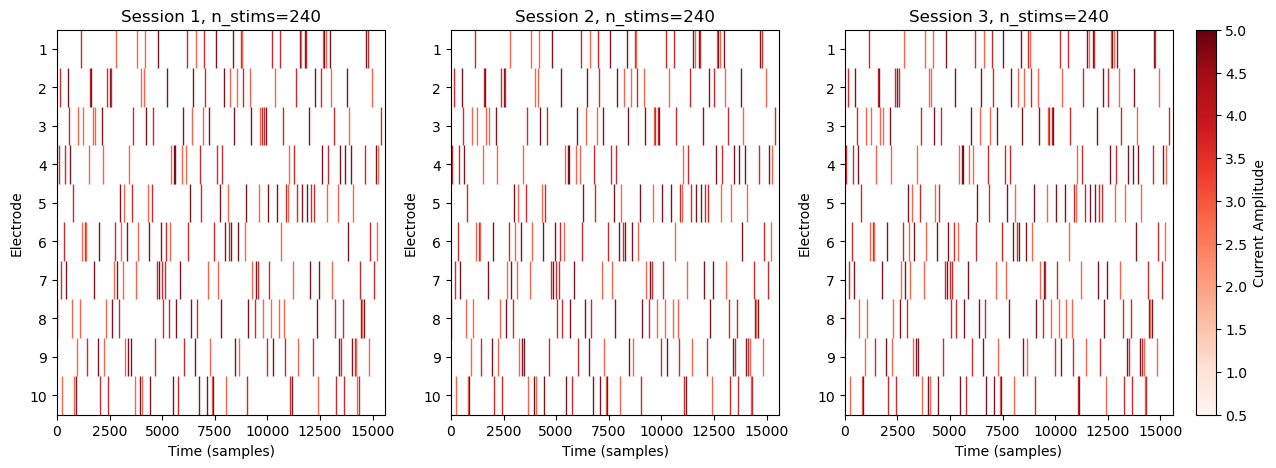

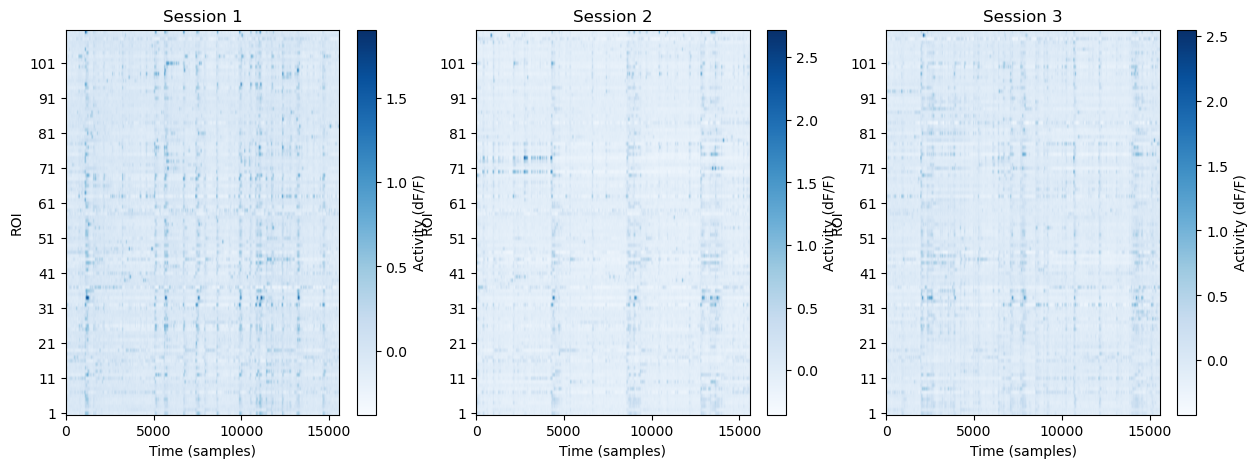

In [113]:
stim_times_sess = []
for session in range(3):
    stim_times = np.zeros((dfof[session].shape[0], 10))
    for config in range(1, 31): # last config is no stim
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
        print(f'Config {config}: Electrode {electrode}, Current {current}')
        for i in range(8):
            config_time = times[session][i,config-1]
            stim_times[config_time, electrode] = current
    stim_times_sess.append(stim_times) # len 3, each (n_times, n_electrodes)

stim_times_sess = np.array(stim_times_sess)
print ("Stim times sess shape: ", stim_times_sess.shape)

# how many frames have no stimulation?
n_no_stim = [stim_times_sess[i].shape[0] - np.count_nonzero(stim_times_sess[i]) for i in range(3)]
print (f'Number of no-stim frames per session: {",".join([str(n) for n in n_no_stim])} assuming 1 ms current pulse')

# pairs of (session, roi) that are known to have good responses
good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
              (12,26),(13,22),(14,22),(14,23),
              (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
              (29,26),(29,31),(30,26),(30,27),(30,31)]


plot_stim_ticks(stim_times_sess, session_ids=None, tick_width=6, cmap_name='Reds',
                figsize=(15, 5), out_path=f'rnn_training/{DATETIME_STAMP}/stim_times_sessions_ticks.png',
                invert_y=True)

plot_activity_per_session(dfof, session_ids=None,
                          figsize=(15,5),
                          out_path=f'rnn_training/{DATETIME_STAMP}/activity_sessions.png')

In [123]:
from utils import make_snippets

initial_conds, activity_snippets, stim_snippets = make_snippets(dfof, stim_times_sess, SNIPPET_LENGTH, overlap=SNIPPET_OVERLAP)
print (f"Initial conds shape: {initial_conds.shape}")
print (f'Activity snippets shape: {activity_snippets.shape}') # (num_samples, snippet_length, num_rois)
print (f'Stim snippets shape: {stim_snippets.shape}') # (num_samples, snippet_length, num_configs)
logging.info(f"Iniitial conds fshape: {initial_conds.shape}")
logging.info(f'Activity snippets shape: {activity_snippets.shape}')
logging.info(f'Stim snippets shape: {stim_snippets.shape}')
logging.info(f'Snippet overlap: {SNIPPET_OVERLAP}')



Initial conds shape: (46713, 110)
Activity snippets shape: (46713, 30, 110)
Stim snippets shape: (46713, 30, 10)
2026-01-04 22:48:27,269 INFO: Iniitial conds fshape: (46713, 110)
2026-01-04 22:48:27,269 INFO: Activity snippets shape: (46713, 30, 110)
2026-01-04 22:48:27,270 INFO: Stim snippets shape: (46713, 30, 10)
2026-01-04 22:48:27,270 INFO: Snippet overlap: True


In [ ]:
# ----- Create snippets DataFrame and split data -----
from utils import make_snippets_df, snippets_df_to_arrays
from sklearn.model_selection import train_test_split

# Create snippets DataFrame from trials_df
# overlap=True creates overlapping snippets (like original make_snippets), giving ~46k+ snippets
# overlap=False only creates snippets aligned to trial stim times (~744 snippets)
# stride controls step size for overlapping snippets (1=full overlap, length=non-overlapping)
SNIPPET_STRIDE = 1  # Set to SNIPPET_LENGTH for non-overlapping

snippets_df = make_snippets_df(trials_df, dfof, stim_times_sess, SNIPPET_LENGTH, 
                                overlap=SNIPPET_OVERLAP, stride=SNIPPET_STRIDE)
logging.info(f"Snippets DataFrame shape: {snippets_df.shape}")
logging.info(f"Valid snippets: {snippets_df['valid'].sum()}")
logging.info(f"Snippets with stim at t=0: {snippets_df['stim_at_t0'].sum()}")

# ==================== SPLIT STRATEGY ====================
# Choose one of: 'random', 'session', 'trial', 'config', 'electrode', 'current', 'stim_at_t0'
SPLIT_STRATEGY = 'trial'

# For 'session': which sessions to hold out for test (only valid if SPLIT_STRATEGY=='session')
HOLDOUT_SESSIONS = [2]  # e.g., session 2 as test

# For 'trial': which trial indices to hold out (only valid if SPLIT_STRATEGY=='trial')
HOLDOUT_TRIALS = [1, 7]  # e.g., trials 1 and 7 as test (0-indexed, range 0-7)

# For 'config': which configs to hold out (only valid if SPLIT_STRATEGY=='config')
HOLDOUT_CONFIGS = [28, 29, 30]  # e.g., configs 28-30 as test

# For 'electrode': which electrodes to hold out (only valid if SPLIT_STRATEGY=='electrode')
HOLDOUT_ELECTRODES = [9]  # e.g., electrode 9 as test

# For 'current': which current levels to hold out (only valid if SPLIT_STRATEGY=='current')
HOLDOUT_CURRENTS = [5]  # e.g., highest current as test

# ========================================================

valid_df = snippets_df[snippets_df['valid']].copy()
# Random split proportions if using random SPLIT_STRATEGY
VAL_SIZE = 0.15 
TEST_SIZE = 0.15

# Helper functions to check if ANY stim in snippet matches holdout criteria
def contains_any_trial(all_trials, holdout_trials):
    """Check if any trial in all_trials is in holdout_trials"""
    return any(t in holdout_trials for t in all_trials)

def contains_any_config(all_configs, holdout_configs):
    """Check if any config in all_configs is in holdout_configs"""
    return any(c in holdout_configs for c in all_configs)

def contains_any_electrode(all_electrodes, holdout_electrodes):
    """Check if any electrode in all_electrodes is in holdout_electrodes"""
    return any(e in holdout_electrodes for e in all_electrodes)

def contains_any_current(all_currents, holdout_currents):
    """Check if any current in all_currents is in holdout_currents"""
    return any(c in holdout_currents for c in all_currents)

if SPLIT_STRATEGY == 'random':
    # Completely random split
    train_val_df, test_df = train_test_split(valid_df, test_size=TEST_SIZE, random_state=SEED)
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE/(1-TEST_SIZE), random_state=SEED)
    logging.info(f"Random split: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'session':
    # Hold out specific sessions
    test_df = valid_df[valid_df['session'].isin(HOLDOUT_SESSIONS)]
    train_val_df = valid_df[~valid_df['session'].isin(HOLDOUT_SESSIONS)]
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Session holdout {HOLDOUT_SESSIONS}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'trial':
    # Hold out snippets where ANY stim in the snippet is from a holdout trial
    holdout_mask = valid_df['all_trials'].apply(lambda x: contains_any_trial(x, HOLDOUT_TRIALS))
    test_df = valid_df[holdout_mask]
    train_val_df = valid_df[~holdout_mask]
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Trial holdout {HOLDOUT_TRIALS}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'config':
    # Hold out snippets where ANY stim in the snippet is from a holdout config
    holdout_mask = valid_df['all_configs'].apply(lambda x: contains_any_config(x, HOLDOUT_CONFIGS))
    test_df = valid_df[holdout_mask]
    train_val_df = valid_df[~holdout_mask]
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Config holdout {HOLDOUT_CONFIGS}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'electrode':
    # Hold out snippets where ANY stim in the snippet is from a holdout electrode
    holdout_mask = valid_df['all_electrodes'].apply(lambda x: contains_any_electrode(x, HOLDOUT_ELECTRODES))
    test_df = valid_df[holdout_mask]
    train_val_df = valid_df[~holdout_mask]
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Electrode holdout {HOLDOUT_ELECTRODES}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

elif SPLIT_STRATEGY == 'current':
    # Hold out snippets where ANY stim in the snippet is from a holdout current level
    holdout_mask = valid_df['all_currents'].apply(lambda x: contains_any_current(x, HOLDOUT_CURRENTS))
    test_df = valid_df[holdout_mask]
    train_val_df = valid_df[~holdout_mask]
    train_df, val_df = train_test_split(train_val_df, test_size=VAL_SIZE, random_state=SEED)
    logging.info(f"Current holdout {HOLDOUT_CURRENTS}: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

else:
    raise ValueError(f"Unknown split strategy: {SPLIT_STRATEGY}")

# ----- Remove overlapping snippets to prevent data contamination -----
# Quarantine based on actual HOLDOUT STIM TIMES, not all test/val snippet starts
# This is more conservative - only removes snippets whose frames overlap with holdout stim events

def get_holdout_stim_times(trials_df, holdout_trials, sessions):
    """Get actual stim times for holdout trials, grouped by session"""
    holdout_stims = trials_df[trials_df['trial'].isin(holdout_trials)]
    stim_times_by_session = {}
    for session in sessions:
        session_stims = holdout_stims[holdout_stims['session'] == session]['stim_time'].values
        stim_times_by_session[session] = set(session_stims)
    return stim_times_by_session

def find_snippets_near_stim_times(source_df, stim_times_by_session, snippet_length, buffer_frames=None):
    """
    Find indices in source_df whose frames overlap with or are within buffer of stim times.
    
    A snippet [start, start+L) is quarantined if any of its frames is within buffer_frames
    of a holdout stim time. Default buffer is snippet_length (one L before/after stim).
    """
    if buffer_frames is None:
        buffer_frames = snippet_length
    
    overlapping_indices = set()
    
    for idx, row in source_df.iterrows():
        session = row['session']
        start = row['snippet_start']
        end = start + snippet_length
        
        if session not in stim_times_by_session:
            continue
            
        # Check if this snippet's time window overlaps with buffer around any stim time
        for stim_time in stim_times_by_session[session]:
            # Stim buffer zone is [stim_time - buffer, stim_time + buffer)
            # Snippet window is [start, end)
            # They overlap if: start < stim_time + buffer AND end > stim_time - buffer
            if start < stim_time + buffer_frames and end > stim_time - buffer_frames:
                overlapping_indices.add(idx)
                break
    
    return overlapping_indices

# Get actual holdout stim times (not all test snippet starts)
sessions = sorted(valid_df['session'].unique())
holdout_stim_times = get_holdout_stim_times(trials_df, HOLDOUT_TRIALS, sessions)
logging.info(f"Holdout stim times per session: { {s: len(t) for s, t in holdout_stim_times.items()} }")

# Remove train snippets that are within buffer of holdout stim times
train_overlap = find_snippets_near_stim_times(train_df, holdout_stim_times, SNIPPET_LENGTH)
train_df_clean = train_df.drop(index=train_overlap)
logging.info(f"Removed {len(train_overlap)} train snippets near holdout stim times")

# Remove val snippets that are within buffer of holdout stim times  
val_overlap = find_snippets_near_stim_times(val_df, holdout_stim_times, SNIPPET_LENGTH)
val_df_clean = val_df.drop(index=val_overlap)
logging.info(f"Removed {len(val_overlap)} val snippets near holdout stim times")

# Update the dataframes
train_df = train_df_clean
val_df = val_df_clean

# Log split summary
logging.info(f"=== Split Summary ({SPLIT_STRATEGY}) after removing overlaps ===")
logging.info(f"Train: {len(train_df)} samples")
logging.info(f"  Sessions: {sorted(train_df['session'].unique())}")
logging.info(f"  First configs with stim_at_t0: {sorted(train_df[train_df['stim_at_t0']]['first_config'].unique())}")
logging.info(f"Val: {len(val_df)} samples")
logging.info(f"Test: {len(test_df)} samples")
logging.info(f"  Sessions: {sorted(test_df['session'].unique())}")

2026-01-04 23:10:27,925 INFO: Snippets DataFrame shape: (46713, 18)
2026-01-04 23:10:27,928 INFO: Valid snippets: 46713
2026-01-04 23:10:27,928 INFO: Snippets with stim at t=0: 720
2026-01-04 23:10:27,970 INFO: Trial holdout [1, 7]: train=35116, val=6197, test=5400
2026-01-04 23:10:30,523 INFO: Removed 12037 train snippets overlapping with test
2026-01-04 23:10:31,972 INFO: Removed 23079 train snippets overlapping with val
2026-01-04 23:10:32,423 INFO: Removed 2141 val snippets overlapping with test
2026-01-04 23:10:32,425 INFO: === Split Summary (trial) after removing overlaps ===
2026-01-04 23:10:32,425 INFO: Train: 0 samples
2026-01-04 23:10:32,426 INFO:   Sessions: []
2026-01-04 23:10:32,427 INFO:   First configs with stim_at_t0: []
2026-01-04 23:10:32,427 INFO: Val: 4056 samples
2026-01-04 23:10:32,427 INFO: Test: 5400 samples
2026-01-04 23:10:32,428 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]


In [128]:

# --- prepare datasets using DataFrame-based SeqDataset ---
batch_size = 8
logging.info(f'Batch size: {batch_size}')
logging.info(f'Split strategy: {SPLIT_STRATEGY}')

train_ds = SeqDataset(df=train_df)
val_ds = SeqDataset(df=val_df)
test_ds = SeqDataset(df=test_df)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() - 1, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, pin_memory=True)

logging.info("Dataset sizes -> train: %d, val: %d, test: %d",
             len(train_ds), len(val_ds), len(test_ds))

# --- model, loss, optimizer ---
# Get dimensions from the dataset
sample_stim, _ = train_ds[0]
input_size = sample_stim[0].shape[1]  # n_electrodes
output_size = train_ds.Y.shape[2]     # n_rois
units = 128
logging.info(f'Train input size: {input_size}')
logging.info(f'Train output size: {output_size}')
logging.info(f'Hidden state size: {units}')
logging.info(f'Number of GRU layers: {NUM_LAYERS}')
model = RNNModel(input_size=input_size, units=units, output_size=output_size, num_layers=NUM_LAYERS).to(device)
logging.info(f'Model architecture:\\n{model}')

loss_type = "mae"
lr = 0.0005
regularize = 0
if loss_type == 'mse':
    criterion = nn.MSELoss()
elif loss_type == 'mae':
    criterion = nn.L1Loss()
else:
    criterion = nn.MSELoss()



optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=regularize)
logging.info(f"Learning rate {lr}")
logging.info(f"Optimizer: {optimizer}")
logging.info(f"Loss type: {loss_type}")
logging.info(f"Regularization coefficient: {regularize}")

# Example training sample
example_input, example_target = train_ds[0]
# print (f'Example input: {example_input[0]}, \n\nactivity_initial: {example_input[1]}')


2026-01-04 22:50:45,696 INFO: Batch size: 8
2026-01-04 22:50:45,697 INFO: Split strategy: trial


ValueError: need at least one array to stack

In [ ]:
from tqdm.notebook import tqdm
import time

use_amp = True

# --- training loop with epoch timing and progress bars ---
best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}
scaler = torch.amp.GradScaler("mps" ,enabled=use_amp)
epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc='Epochs', unit='ep')
for epoch in epoch_pbar:
    t0 = time.perf_counter()

    model.train()
    running_loss = 0.0
    for (inputs, activity_initial), targets in tqdm(train_loader, desc=f'Epoch {epoch} Train', leave=False, unit='batch'):
        inputs = inputs.to(device)
        activity_initial = activity_initial.to(device)
        targets = targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=use_amp):
           outputs = model((inputs, activity_initial))
           loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(train_loss)
    logging.info(f"Epoch {epoch} Train loss: {train_loss}")

    model.eval()
    val_running = 0.0
    with torch.no_grad(), torch.autocast(
        device_type=device_type,
        dtype=torch.float16,
        enabled=use_amp):
        for (inputs, activity_initial), targets in tqdm(val_loader, desc=f'Epoch {epoch} Val', leave=False, unit='batch'):
            inputs = inputs.to(device)
            activity_initial = activity_initial.to(device)
            targets = targets.to(device)
            outputs = model((inputs, activity_initial))
            val_loss = criterion(outputs, targets)
            val_running += val_loss.item() * inputs.size(0)

    val_loss = val_running / len(val_loader.dataset)
    history['val_loss'].append(val_loss)
    logging.info(f'Epoch {epoch} Validation loss: {val_loss}')


    # stop if no improvement for 5 epochs
    if epoch > 5 and all(history['val_loss'][-i] >= history['val_loss'][-i-1] for i in range(1,6)):
        logging.info ("Early stopping due to no improvement in validation loss for 5 consecutive epochs.")
        break


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_filepath)
        logging.info (f'  Saved best model with val loss {best_val_loss:.6f} to {checkpoint_filepath}')



    epoch_time = time.perf_counter() - t0
    epoch_pbar.set_postfix({'train': f'{train_loss:.6f}', 'val': f'{val_loss:.6f}', 'sec': f'{epoch_time:.2f}'})



Epochs:   0%|          | 0/20 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-04 22:03:56,702 INFO: Epoch 1 Train loss: 0.07436380331708442


Epoch 1 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-04 22:04:02,381 INFO: Epoch 1 Validation loss: 0.07016450907923315
2026-01-04 22:04:02,386 INFO:   Saved best model with val loss 0.070165 to rnn_training/20260104_214052/best_model.pth


Epoch 2 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:05:28,031 INFO: Epoch 2 Train loss: 0.06849995715478056


Epoch 2 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:05:32,647 INFO: Epoch 2 Validation loss: 0.06716276233763595
2026-01-04 22:05:32,652 INFO:   Saved best model with val loss 0.067163 to rnn_training/20260104_214052/best_model.pth


Epoch 3 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:06:57,307 INFO: Epoch 3 Train loss: 0.06674625466768076


Epoch 3 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:07:01,961 INFO: Epoch 3 Validation loss: 0.06621738486228947
2026-01-04 22:07:01,966 INFO:   Saved best model with val loss 0.066217 to rnn_training/20260104_214052/best_model.pth


Epoch 4 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:08:25,395 INFO: Epoch 4 Train loss: 0.06594582311728406


Epoch 4 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:08:30,011 INFO: Epoch 4 Validation loss: 0.06542340310567511
2026-01-04 22:08:30,015 INFO:   Saved best model with val loss 0.065423 to rnn_training/20260104_214052/best_model.pth


Epoch 5 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:09:56,724 INFO: Epoch 5 Train loss: 0.0652277876713416


Epoch 5 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:10:01,441 INFO: Epoch 5 Validation loss: 0.06478156750444498
2026-01-04 22:10:01,446 INFO:   Saved best model with val loss 0.064782 to rnn_training/20260104_214052/best_model.pth


Epoch 6 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:11:25,034 INFO: Epoch 6 Train loss: 0.06461068727172643


Epoch 6 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:11:29,614 INFO: Epoch 6 Validation loss: 0.06441910929303031
2026-01-04 22:11:29,620 INFO:   Saved best model with val loss 0.064419 to rnn_training/20260104_214052/best_model.pth


Epoch 7 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:12:54,027 INFO: Epoch 7 Train loss: 0.06400488423988793


Epoch 7 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:12:58,755 INFO: Epoch 7 Validation loss: 0.06364414545937908
2026-01-04 22:12:58,760 INFO:   Saved best model with val loss 0.063644 to rnn_training/20260104_214052/best_model.pth


Epoch 8 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:14:23,010 INFO: Epoch 8 Train loss: 0.06341166724436571


Epoch 8 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:14:27,707 INFO: Epoch 8 Validation loss: 0.06301167884136792
2026-01-04 22:14:27,712 INFO:   Saved best model with val loss 0.063012 to rnn_training/20260104_214052/best_model.pth


Epoch 9 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:15:51,363 INFO: Epoch 9 Train loss: 0.0629324685349132


Epoch 9 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:15:56,020 INFO: Epoch 9 Validation loss: 0.0625438992113498
2026-01-04 22:15:56,025 INFO:   Saved best model with val loss 0.062544 to rnn_training/20260104_214052/best_model.pth


Epoch 10 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:17:19,685 INFO: Epoch 10 Train loss: 0.062411367177854914


Epoch 10 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:17:24,383 INFO: Epoch 10 Validation loss: 0.06203249583494226
2026-01-04 22:17:24,388 INFO:   Saved best model with val loss 0.062032 to rnn_training/20260104_214052/best_model.pth


Epoch 11 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:18:48,069 INFO: Epoch 11 Train loss: 0.06200648730584446


Epoch 11 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:18:52,876 INFO: Epoch 11 Validation loss: 0.061755562667791065
2026-01-04 22:18:52,881 INFO:   Saved best model with val loss 0.061756 to rnn_training/20260104_214052/best_model.pth


Epoch 12 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:20:20,489 INFO: Epoch 12 Train loss: 0.06162161269083506


Epoch 12 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:20:25,275 INFO: Epoch 12 Validation loss: 0.06137516742735261
2026-01-04 22:20:25,281 INFO:   Saved best model with val loss 0.061375 to rnn_training/20260104_214052/best_model.pth


Epoch 13 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:21:50,011 INFO: Epoch 13 Train loss: 0.061300565808304855


Epoch 13 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:21:54,904 INFO: Epoch 13 Validation loss: 0.06100339262716086
2026-01-04 22:21:54,909 INFO:   Saved best model with val loss 0.061003 to rnn_training/20260104_214052/best_model.pth


Epoch 14 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:23:18,187 INFO: Epoch 14 Train loss: 0.06099499295498285


Epoch 14 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:23:22,956 INFO: Epoch 14 Validation loss: 0.060721744517735085
2026-01-04 22:23:22,961 INFO:   Saved best model with val loss 0.060722 to rnn_training/20260104_214052/best_model.pth


Epoch 15 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:24:45,747 INFO: Epoch 15 Train loss: 0.06062887211800663


Epoch 15 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:24:50,496 INFO: Epoch 15 Validation loss: 0.0604259921850056
2026-01-04 22:24:50,500 INFO:   Saved best model with val loss 0.060426 to rnn_training/20260104_214052/best_model.pth


Epoch 16 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:26:13,422 INFO: Epoch 16 Train loss: 0.06041016607687189


Epoch 16 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:26:18,216 INFO: Epoch 16 Validation loss: 0.060137794493852474
2026-01-04 22:26:18,221 INFO:   Saved best model with val loss 0.060138 to rnn_training/20260104_214052/best_model.pth


Epoch 17 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:27:41,232 INFO: Epoch 17 Train loss: 0.06011425489294147


Epoch 17 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:27:46,033 INFO: Epoch 17 Validation loss: 0.0599674786700873
2026-01-04 22:27:46,038 INFO:   Saved best model with val loss 0.059967 to rnn_training/20260104_214052/best_model.pth


Epoch 18 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:29:08,863 INFO: Epoch 18 Train loss: 0.05993141966392527


Epoch 18 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:29:13,584 INFO: Epoch 18 Validation loss: 0.059825716456141625
2026-01-04 22:29:13,588 INFO:   Saved best model with val loss 0.059826 to rnn_training/20260104_214052/best_model.pth


Epoch 19 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:30:35,558 INFO: Epoch 19 Train loss: 0.05975483198751775


Epoch 19 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:30:40,122 INFO: Epoch 19 Validation loss: 0.05962169067908763
2026-01-04 22:30:40,127 INFO:   Saved best model with val loss 0.059622 to rnn_training/20260104_214052/best_model.pth


Epoch 20 Train:   0%|          | 0/4677 [00:00<?, ?batch/s]

2026-01-04 22:32:07,861 INFO: Epoch 20 Train loss: 0.0595818364329602


Epoch 20 Val:   0%|          | 0/826 [00:00<?, ?batch/s]

2026-01-04 22:32:12,580 INFO: Epoch 20 Validation loss: 0.05943207347060796
2026-01-04 22:32:12,585 INFO:   Saved best model with val loss 0.059432 to rnn_training/20260104_214052/best_model.pth


In [ ]:
model = RNNModel(input_size=input_size, units=units, output_size=output_size, num_layers=NUM_LAYERS)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
test_running = 0.0
with torch.no_grad():
    for (inputs, activity_initial), targets in tqdm(test_loader, desc='Test', unit='batch'):
        inputs = inputs.to(device)
        activity_initial = activity_initial.to(device)
        targets = targets.to(device)
        outputs = model((inputs, activity_initial))
        loss = criterion(outputs, targets)
        test_running += loss.item() * inputs.size(0)

test_loss = test_running / len(test_loader.dataset)
logging.info(f'Test Loss: {test_loss:.6f}')

Test:   0%|          | 0/338 [00:00<?, ?batch/s]

2026-01-04 22:33:17,892 INFO: Test Loss: 0.062061


In [ ]:
model = RNNModel(input_size=input_size, units=units, output_size=output_size, num_layers=NUM_LAYERS)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
test_running = 0.0

plot_inputs = []
plot_outputs = []
plot_targets = []
with torch.no_grad():
    for (inputs, activity_initial), targets in tqdm(test_loader, desc='Test', unit='batch'):
        inputs = inputs.to(device)
        activity_initial = activity_initial.to(device)
        targets = targets.to(device)
        outputs = model((inputs, activity_initial))
        plot_inputs.append(inputs.cpu().numpy())
        plot_outputs.append(outputs.cpu().numpy()) # n batches
        plot_targets.append(targets.cpu().numpy())
plot_inputs = np.concatenate(plot_inputs, axis=0)
plot_outputs = np.concatenate(plot_outputs, axis=0)
plot_targets = np.concatenate(plot_targets, axis=0)

print ("Inputs shape: ", plot_inputs.shape)
print ("Predictions shape: ", plot_outputs.shape)
print ("Targets shape: ", plot_targets.shape)




Test:   0%|          | 0/338 [00:00<?, ?batch/s]

Inputs shape:  (2700, 30, 10)
Predictions shape:  (2700, 30, 110)
Targets shape:  (2700, 30, 110)


In [ ]:
plt.figure(figsize=(10, 5))
for config, roi in good_pairs: # TODO: Why are only ROIs from a certain range below 30 in the "good pairs"
    print (f"Plotting {roi} prediction over test samples")
    for test_sample in np.random.choice(np.arange(plot_targets.shape[0]), 10, replace=False):
        plt.figure(figsize=(10, 5))
        input = plot_inputs[test_sample, :, :].squeeze()
        stim_times = np.nonzero(input)[0]
        electrodes = np.nonzero(input)[1]
        for i, time in enumerate(stim_times):
            current = input[stim_times[i], electrodes[i]]
            if current == 3:
                plt.axvline(x=time, color='r', linestyle='--')
            elif current == 4:
                plt.axvline(x=time, color='b', linestyle='--')
            elif current == 5:
                plt.axvline(x=time, color='g', linestyle='--')
            else:
                pass
        plt.title("ROI {}, test sample {}: ".format(roi, test_sample))
        # corr = np.corrcoef(plot_outputs[test_sample, :, roi], plot_targets[test_sample, :, roi])
        ax = plt.gca()
        corr_value = np.corrcoef(plot_outputs[test_sample, :, roi],
                                 plot_targets[test_sample, :, roi])[0, 1]
        ax.text(0.98, 0.98, f"corr={corr_value:.3f}", transform=ax.transAxes,
                ha='right', va='top')

        plt.plot(plot_outputs[test_sample, : , roi], 'blue', label="predicted");
        plt.plot(plot_targets[test_sample, :, roi], 'orange', label="ground truth");
        plt.grid()
        plt.legend()
        plt.savefig(os.path.join("rnn_training", DATETIME_STAMP, f"{roi}_{test_sample}.png"))
        plt.close()

Plotting 26 prediction over test samples
Plotting 22 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 27 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 26 prediction over test samples
Plotting 22 prediction over test samples
Plotting 22 prediction over test samples
Plotting 23 prediction over test samples
Plotting 22 prediction over test samples
Plotting 23 prediction over test samples
Plotting 21 prediction over test samples
Plotting 21 prediction over test samples
Plotting 31 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 31 prediction over test samples
Plotting 26 prediction over test samples
Plotting 27 pred

<Figure size 1000x500 with 0 Axes>

# Random overlay of timeseries for each roy overlaid

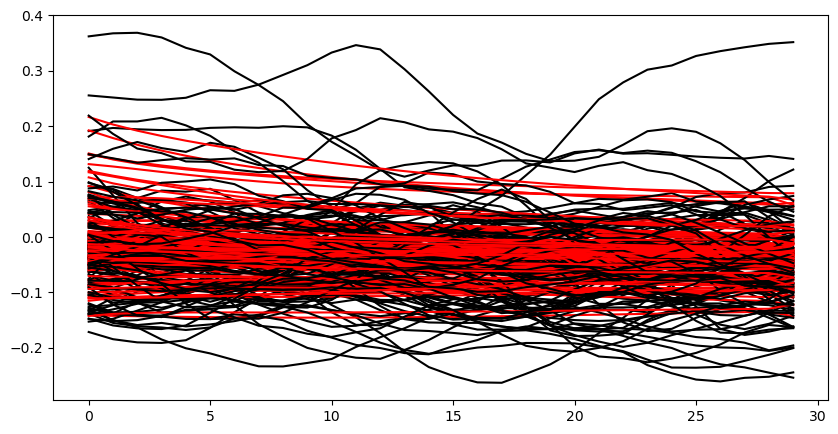

In [ ]:
plt.figure(figsize=(10, 5))
for roi in range(110):
    plt.plot(plot_outputs[0,  :,  roi], 'r')
    plt.plot(plot_targets[0,  :,  roi], 'k')


## Loss over Epochs Plot

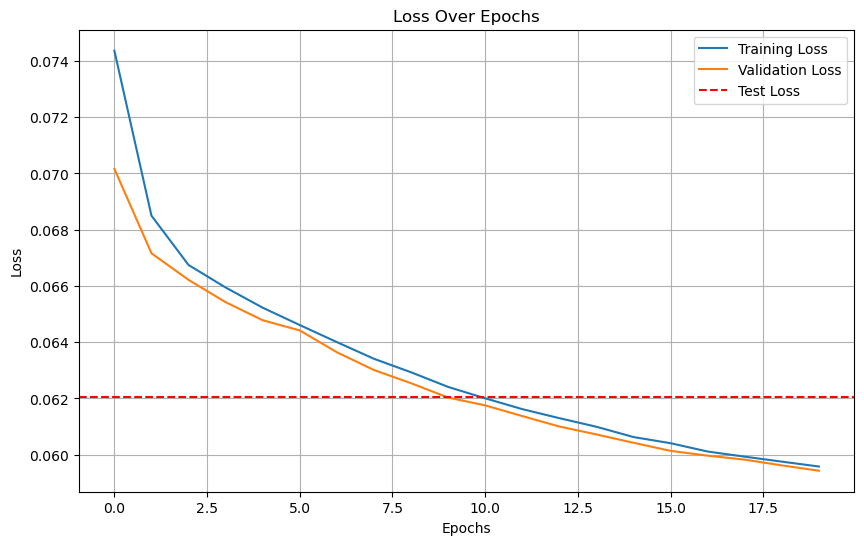

In [ ]:
# ----- Plot training, validation, and test loss -----
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'rnn_training/{DATETIME_STAMP}/loss_over_epochs.png')
plt.show()

## Stim times and activity plot

In [ ]:
stim_times_sess = []
for session in range(3):
    stim_times = np.zeros((dfof[session].shape[0], 10))
    for config in range(1, 31): # last config is no stim
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
        print(f'Config {config}: Electrode {electrode}, Current {current}')
        for i in range(8):
            config_time = times[session][i,config-1]
            stim_times[config_time, electrode] = current
    stim_times_sess.append(stim_times) # len 3, each (n_times, n_electrodes)

stim_times_sess = np.array(stim_times_sess)
print ("Stim times sess shape: ", stim_times_sess.shape)

# how many frames have no stimulation?
n_no_stim = [stim_times_sess[i].shape[0] - np.count_nonzero(stim_times_sess[i]) for i in range(3)]
print (f'Number of no-stim frames per session: {",".join([str(n) for n in n_no_stim])} assuming 1 ms current pulse')

# pairs of (session, roi) that are known to have good responses
good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
              (12,26),(13,22),(14,22),(14,23),
              (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
              (29,26),(29,31),(30,26),(30,27),(30,31)]


plot_stim_ticks(stim_times_sess, session_ids=None, tick_width=6, cmap_name='Reds',
                figsize=(15, 5), out_path=f'rnn_training/{DATETIME_STAMP}/stim_times_sessions_ticks.png',
                invert_y=True)

plot_activity_per_session(dfof, session_ids=None,
                          figsize=(15,5),
                          out_path=f'rnn_training/{DATETIME_STAMP}/activity_sessions.png')

(46713, 30, 10)

In [117]:
activity_snippets.shape # should be (n_snippets, snippet_length, n_rois)

(46713, 30, 110)

In [118]:
times[0][0]
configs[0][0].shape

(31,)

In [119]:
# ----- Analyze the fit model -----

model = RNNModel(input_size=input_size, units=units, output_size=output_size, num_layers=NUM_LAYERS)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
# test on a training snippet for shape matching
# create a batch of size 1: inputs shape (1, seq_len, input_size)
inputs = torch.from_numpy(np.expand_dims(stim_snippets[0].astype(np.float32), axis=0)).to(device)

# activity_initial must be the first timestep of the activity snippet, shape (1, output_size)
activity_initial = torch.from_numpy(np.expand_dims(activity_snippets[0][0].astype(np.float32), axis=0)).to(device)
print ("Example output: ",  model((inputs, activity_initial)).shape)

example_roi = 31  # Index of the example ROI to plot
potential_activating_configs = [7, 8, 9, 26, 27, 28, 29, 30]
print ("Stim snippets: ", stim_snippets.shape)

prediction_length = SNIPPET_LENGTH


generated_activity = []
config_list = []
for config in range(1, 32):
    if config != 31:
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
    else:
        electrode = 0  # no stim
        current = 0
    stim_input = np.zeros((1, prediction_length, stim_snippets.shape[2]), dtype=np.float32)
    # select electrodes to activate based on config
    stim_input[0, 0, electrode] = current  # Set the current config
    activity_input = np.expand_dims(initial_condition.astype(np.float32), axis=0)

    # convert to tensors and move to device
    inputs_t = torch.from_numpy(stim_input).to(device)
    activity_t = torch.from_numpy(activity_input).to(device)

    with torch.no_grad():
        outputs = model((inputs_t, activity_t))  # (batch, seq_len, output_size)
    generated = outputs.cpu().numpy()
    generated_activity.append(generated[0])
    config_list.append(config)

generated_activity = np.array(generated_activity)

# ----- Plot the activity of the example ROI -----
plt.figure(figsize=(10, 6))
for isample in range(generated_activity.shape[0]):
    if config_list[isample] in potential_activating_configs:
        color = 'r'
    else:
        color = 'b'
        
    plt.plot(generated_activity[isample, :, example_roi-1], alpha=0.3, color=color)

plt.title(f'Activity of ROI {example_roi} for all configs')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.grid(True)
plt.savefig(f'rnn_training/{DATETIME_STAMP}/generated_activity_roi{example_roi}.png')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'rnn_training/20260104_224745/best_model.pth'

In [120]:
# ----- Analyze the fit model -----
prediction_length = SNIPPET_LENGTH  # Length of the prediction snippet

for config, roi in good_pairs:
    electrode = (config-1) // 3
    current = (config-1)%3 + 3
    generated_activity = []
    electrode = 1 # Electrode to stimulate

    config_list = []
    idx = 0
    for current in np.arange(2, 6, 0.1):

        stim_input = np.zeros((1, prediction_length, stim_snippets.shape[2]))
        stim_input[0, 0, electrode] = current  # Set the current config
        activity_input = np.expand_dims(initial_condition, axis=0)  # Add batch dimension
        generated = model((stim_input, activity_input))

        generated_activity.append(generated[0, :, :].detach().cpu().numpy())
        if current in [3, 4, 5] and electrode < 10:
            config_list.append(idx)
        else:
            config_list.append(-1)
        idx += 1
    generated_activity = np.array(generated_activity)

    # ----- Plot the activity of the example ROI -----
    plt.figure(figsize=(10, 6))
    for isample in range(generated_activity.shape[0]):
        if config_list[isample] in potential_activating_configs:
            color = 'r'
        else:
            color = 'b'

        plt.plot(generated_activity[isample, :, example_roi-1], alpha=0.3, color=color)

    plt.title(f'Activity of ROI {example_roi} for all configs with electrode {electrode}')
    plt.xlabel('Time')
    plt.ylabel('Activity')
    plt.grid(True)
    plt.savefig(f'rnn_training/{DATETIME_STAMP}/generated_activity_roi{example_roi}_current_sweep.png')

    # plot activtiy at time 't' vs current
    plt.figure(figsize=(10, 6))
    time_point = 10
    activities = generated_activity[:, time_point, example_roi-1]
    currents = np.arange(2, 6, 0.1)
    plt.plot(currents, activities, 'o-')
    # plt.axvline([3, 4, 5], [-1, 1], color='r', linestyle='--')
    plt.title(f'Activity of ROI {example_roi} at time {time_point} vs Current')
    plt.xlabel('Current')
    plt.ylabel('Activity')
    plt.grid(True)
    plt.savefig(f'rnn_training/{DATETIME_STAMP}/generated_activity_roi{example_roi}_current_sweep.png')

    # plt.show()

NameError: name 'potential_activating_configs' is not defined

<Figure size 1000x600 with 0 Axes>

torch.Size([30])
Jacobian shape: (30, 30, 10)


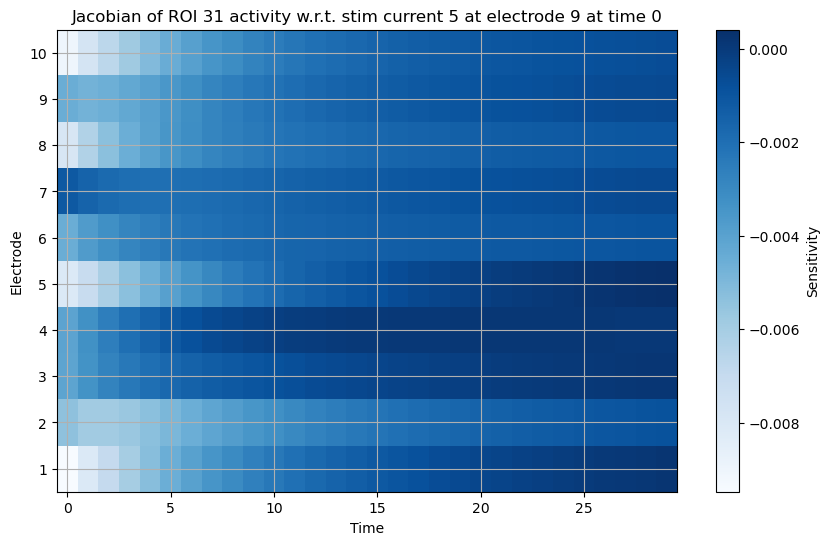

In [ ]:
# what does the jacobian look like?

# # pairs of (session, roi) that are known to have good responses
##good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
 #             (12,26),(13,22),(14,22),(14,23),
  #            (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
  #            (29,26),(29,31),(30,26),(30,27),(30,31)]

example_roi = 31  # Index of the example ROI to plot
config = 30
electrode = (config-1) // 3
current = (config-1)%3 + 3


prediction_length = SNIPPET_LENGTH  # Length of the prediction snippet
initial_condition = 0 +  0 * activity_snippets[200, 0,  :].astype(np.float32) # Initial condition

stim_input = np.zeros((1, prediction_length, stim_snippets.shape[2]), dtype=np.float32)
stim_input[0, 0, electrode] = current  # Set the current config
activity_input = np.expand_dims(initial_condition, axis=0)  # Add batch dimension
stim_input_t = torch.from_numpy(stim_input).to(device).requires_grad_(True)
activity_input_t = torch.from_numpy(activity_input).to(device)
generated = model((stim_input_t, activity_input_t))
roi_activity = generated[0, :, example_roi-1]
print (roi_activity.shape)
jacobian = []
for t in range(prediction_length):
    grad_outputs = torch.zeros_like(roi_activity)
    grad_outputs[t] = 1.0
    grads = torch.autograd.grad(outputs=roi_activity, inputs=stim_input_t,
                                grad_outputs=grad_outputs,
                                retain_graph=True)
    # grads is a tuple (one entry per input). For a single Tensor input:
    grad_tensor = grads[0]  # Tensor or None; expected shape (1, prediction_length, n_electrodes)

    # handle possible None and extract batch-0 slice (seq_len, n_electrodes)
    if grad_tensor is None:
        jacobian.append(np.zeros((prediction_length, stim_input_t.shape[2]), dtype=np.float32))
    else:
        jacobian.append(grad_tensor[0].detach().cpu().numpy())
jacobian = np.array(jacobian)  # shape (prediction_length, prediction_length, n_electrodes)
print (f'Jacobian shape: {jacobian.shape}')
# plot jacobian as heatmap
plt.figure(figsize=(10, 6))
plt.imshow(jacobian[:, 0, :].T, aspect='auto', cmap='Blues', origin='lower')
plt.colorbar(label='Sensitivity')
plt.title(f'Jacobian of ROI {example_roi} activity w.r.t. stim current {current} at electrode {electrode} at time 0')
plt.xlabel('Time')
plt.ylabel('Electrode')
plt.yticks(np.arange(stim_input.shape[2]), labels=[str(i+1) for i in range(stim_input.shape[2])])
plt.grid()
plt.savefig(f'rnn_training/{DATETIME_STAMP}/jacobian_roi{example_roi}.png')
plt.show()


In [121]:
# Perform UMAP on the hidden states
model.eval()
hidden_states = []
currents = []
electrodes = []
configs_tracker = []

with torch.no_grad():
    for (inputs, activity_initial), targets in tqdm(test_loader, desc='Extract Hidden States', unit='batch'):
        #inputs shape  batch, time, electrodes
        batch_currents = []
        batch_electrodes = []
        batch_configs = []
        t_configs = []
        for idx in range(inputs.shape[0]):
            # look at each sample in batch separately for simplicity but later vectorize
            config_vector = inputs[idx,:,:].cpu().numpy()

            stim_times = np.nonzero(config_vector)[0]
            electrodes_used = np.nonzero(config_vector)[1]

            for t, e in zip(stim_times, electrodes_used):
                # verify config number stays same through all t in a snippet
                current = config_vector[t, e]
                # print (f'Time {t}, Electrode {e}, Current {current}')
                config_num = e * 3 + (int(current) - 3) + 1 # map back to config number
                t_configs.append(config_num)
                print (t_configs)
            # print (stim_times, electrodes_used, t_configs)
            assert all(c == t_configs[0] for c in t_configs), "Multiple configs in one snippet!"
            batch_configs.append(t_configs[0])

            configs_tracker.append(batch_configs)
            batch_currents.append(config_vector[t, e]) # should be batch size
            batch_electrodes.append(e) # should be batch size
        currents.append(batch_currents)
        electrodes.append(batch_electrodes)

        inputs = inputs.to(device)
        currents.append(inputs)
        activity_initial = activity_initial.to(device)
        # Project initial activity to hidden state
        h0 = model.initial_state_projection(activity_initial).unsqueeze(0).contiguous()
        out, _ = model.rnn(inputs, h0)
        hidden_states.append(out.cpu().numpy())
print (len(hidden_states))
hidden_states = np.concatenate(hidden_states, axis=0)  # shape (n_samples, seq_len, units)
# print (len(currents), len(electrodes))
# print (len(currents[0]), len(electrodes[0]))
print (len(configs_tracker))
print (len(hidden_states))

assert len(currents) == len(hidden_states)
assert len(stim_snippets) == len(hidden_states)
n_samples, seq_len, units = hidden_states.shape
# hidden_states_reshaped = hidden_states.reshape(-1, units)  # shape (n_samples * seq_len, units)

Extract Hidden States:   0%|          | 0/338 [00:00<?, ?batch/s]

[np.int64(11)]
[np.int64(11), np.int64(11)]
[np.int64(11), np.int64(11), np.int64(11)]
[np.int64(11), np.int64(11), np.int64(11), np.int64(11)]
[np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11)]
[np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11)]
[np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11)]
[np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(11)]


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


RuntimeError: Tensor for argument weight is on cpu but expected on mps

In [ ]:
print (hidden_states.shape)
print (len(configs_tracker))
print (n_samples)

AttributeError: 'list' object has no attribute 'shape'

In [122]:
import umap
umap = umap.UMAP(n_components=2, random_state=SEED)
hidden_states_2d = umap.fit_transform(hidden_states[:, 60, :])  # shape (n_samples * seq_len, 2)
# Plot UMAP results
plt.figure(figsize=(10, 6))
plt.scatter(hidden_states_2d[:, 0], hidden_states_2d[:, 1], s=1, alpha=0.5)
plt.title('UMAP of RNN Hidden States')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid()
plt.savefig(f'rnn_training/{DATETIME_STAMP}/umap_hidden_states.png')
plt.show()


TypeError: list indices must be integers or slices, not tuple

In [ ]:
# Make ROI visual
model = RNNModel(input_size=input_size, units=units, output_size=output_size, num_layers=NUM_LAYERS)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()
num_rois = 110 # TODO: Not hardcode rois/time
for roi in range(num_rois):
    for t in range(1, 15601, SNIPPET_LENGTH):
        init_cond = activity[0][0][t-1 :].astype(np.float32)


In [ ]:
# ============================
# ROI activation video (neutral background)
# ============================

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import animation

session = 0
mat = scipy.io.loadmat("data_with_rois_labeled.mat")
labelMat = np.squeeze(np.array(mat["labelMat"]))
raw_dfof = mat["dfof"][0, session]
times = np.squeeze(mat.get("times", None)[session])
numNeurons = int(np.array(mat["numNeurons"]))

# -------- Convert dfof safely --------
if raw_dfof.dtype == object:
    cell_list = raw_dfof.ravel()
    dfof = np.vstack([np.squeeze(cell) for cell in cell_list])
else:
    dfof = np.array(raw_dfof, dtype=float)

if dfof.shape[0] != numNeurons:
    dfof = dfof.T

T = dfof.shape[1]
print(f"Loaded {numNeurons} ROIs, {T} timepoints")

# -------- Normalize per neuron --------
mean = dfof.mean(axis=1, keepdims=True)
std = dfof.std(axis=1, keepdims=True)
dfof = (dfof - mean) / (std + 1e-8)

# -------- ROI masks --------
roi_ids = np.unique(labelMat)
roi_ids = roi_ids[roi_ids > 0]

roi_masks = {roi: (labelMat == roi) for roi in roi_ids}
roi_mask_all = labelMat > 0

# -------- Figure setup --------
fig, ax = plt.subplots(figsize=(3, 3))

# Background (neutral gray)
bg = ax.imshow(
    np.zeros_like(labelMat),
    cmap="gray",
    vmin=0,
    vmax=1,
)

# Foreground ROI activation (masked outside ROIs)
img = ax.imshow(
    np.ma.masked_where(~roi_mask_all, np.zeros_like(labelMat, dtype=float)),
    cmap="hot",
    vmin=np.percentile(dfof, 5),
    vmax=np.percentile(dfof, 95),
)

ax.axis("off")
cbar = plt.colorbar(img, ax=ax, fraction=0.046)
cbar.set_label("ΔF/F (z-scored)")

title = ax.set_title("")

# -------- Update function --------
def update(frame):
    activation = np.zeros_like(labelMat, dtype=float)

    for roi in roi_ids:
        roi_idx = int(roi) - 1
        if roi_idx < dfof.shape[0]:
            activation[roi_masks[roi]] = dfof[roi_idx, frame]

    img.set_data(np.ma.masked_where(~roi_mask_all, activation))

    title.set_text(f"Frame {frame}")

    return (img,)

# -------- Animate --------
frame_step = 5
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, 200, frame_step),
    interval=50,
    blit=True,
)

# -------- Optional save --------
ani.save("true_roi_activation.mp4", writer="ffmpeg", dpi=60, fps=10,     extra_args=["-preset", "ultrafast", "-crf", "28"],)


In [109]:
# PSTHs like Yuxuans
# For each config, choose neurons of interest and plot PSTHs neurons on rows, session on columns 
# use test_df DataFrame as reference 

import json

# Load neurons of interest from JSON config file
with open('psth_neurons_config.json', 'r') as f:
    psth_config = json.load(f)

neurons_by_config = psth_config['neurons_by_config']
default_neurons = psth_config['default_neurons']

# OFFSET: time within snippet when stim should occur (0 = stim at start, 10 = see 10 frames before stim)
STIM_OFFSET = 10  # frames before stim to show in plot

model = RNNModel(input_size=input_size, units=units, output_size=output_size, num_layers=NUM_LAYERS)
model.load_state_dict(torch.load(checkpoint_filepath, map_location=device))
model.to(device)
model.eval()

# Create psths directory if it doesn't exist
os.makedirs(f'rnn_training/{DATETIME_STAMP}/psths', exist_ok=True)

for config in range(1, 32):  # Iterate through configs 1-31
    # Get neurons of interest for this config from JSON, fall back to default if empty
    neurons_of_interest = neurons_by_config.get(str(config), default_neurons)
    if len(neurons_of_interest) == 0:
        neurons_of_interest = default_neurons
    
    f, ax = plt.subplots(len(neurons_of_interest), 1, figsize=(15, 3*len(neurons_of_interest)), sharex=True, sharey=True)
    # Handle single row case (ax won't be 2D)
    if len(neurons_of_interest) == 1:
        ax = np.array([ax])
        
    # Filter test_df for snippets where stim occurs at the OFFSET time for this config
    matching_df = test_df[(test_df['first_config'] == config) & (test_df['first_stim_time'] == STIM_OFFSET)]
            
    logging.info(f'Config {config} has {len(matching_df)} matching test snippets (stim at t={STIM_OFFSET}), neurons: {neurons_of_interest}')
    if len(matching_df) == 0:
        logging.info(f'No matching snippets for config {config} with stim at offset {STIM_OFFSET}, skipping.')
        plt.close(f)
        continue
    
    # Time axis relative to stim time (negative = before stim, positive = after)
    time_axis = np.arange(SNIPPET_LENGTH) - STIM_OFFSET
    
    # Color mapping for current levels (matching previous plot)
    current_colors = {3: 'red', 4: 'blue', 5: 'green'}
    
    # plot predictions for the config and neurons of interest
    for row_idx, neuron in enumerate(neurons_of_interest):
        stim_lines_added = {3: False, 4: False, 5: False}  # Track which current labels added
        for _, row in matching_df.iterrows():
            stim_input = np.expand_dims(row['stim_snippet'].astype(np.float32), axis=0)
            activity_input = np.expand_dims(row['initial_condition'].astype(np.float32), axis=0)
            stim_input_t = torch.from_numpy(stim_input).to(device)
            activity_input_t = torch.from_numpy(activity_input).to(device)
            actual_activity = row['activity_snippet'][:, neuron-1]  # neuron-1 for MATLAB -> Python idx
            ax[row_idx].plot(time_axis, actual_activity, alpha=0.6, color='red', label='Ground Truth' if _ == matching_df.index[0] else '') 
            with torch.no_grad():
                outputs = model((stim_input_t, activity_input_t))
            roi_activity = outputs[0, :, neuron-1].cpu().numpy()
            ax[row_idx].plot(time_axis, roi_activity, alpha=0.6, color='blue', label='Predicted' if _ == matching_df.index[0] else '')
            
            # Add dashed vertical lines at stimulation times (relative to STIM_OFFSET)
            stim_snippet = row['stim_snippet']
            stim_times_idx = np.nonzero(stim_snippet)[0]
            electrodes_idx = np.nonzero(stim_snippet)[1]
            for t_idx, e_idx in zip(stim_times_idx, electrodes_idx):
                current = int(stim_snippet[t_idx, e_idx])
                color = current_colors.get(current, 'gray')
                label = f'Current {current}' if not stim_lines_added[current] else ''
                ax[row_idx].axvline(x=t_idx - STIM_OFFSET, color=color, linestyle='--', alpha=0.7, label=label)
                stim_lines_added[current] = True
                
        ax[row_idx].set_title(f'Config {config}, Neuron {neuron}')
        ax[row_idx].set_xlabel('Time relative to stim (frames)')
        ax[row_idx].set_ylabel('Activity')
        ax[row_idx].legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f'rnn_training/{DATETIME_STAMP}/psths/config_{config}.png')
    plt.close()

2026-01-04 22:46:50,166 INFO: Config 1 has 3 matching test snippets (stim at t=10), neurons: [7, 22, 26, 78]
2026-01-04 22:46:50,482 INFO: Config 2 has 3 matching test snippets (stim at t=10), neurons: [7, 22, 26, 78]
2026-01-04 22:46:50,780 INFO: Config 3 has 3 matching test snippets (stim at t=10), neurons: [7, 22, 26, 78]
2026-01-04 22:46:51,067 INFO: Config 4 has 3 matching test snippets (stim at t=10), neurons: [19, 47]
2026-01-04 22:46:51,218 INFO: Config 5 has 3 matching test snippets (stim at t=10), neurons: [19, 47]
2026-01-04 22:46:51,365 INFO: Config 6 has 3 matching test snippets (stim at t=10), neurons: [19, 47]
2026-01-04 22:46:51,523 INFO: Config 7 has 3 matching test snippets (stim at t=10), neurons: [7, 16, 26, 27, 31, 37, 59, 78]
2026-01-04 22:46:52,104 INFO: Config 8 has 3 matching test snippets (stim at t=10), neurons: [7, 16, 26, 27, 31, 37, 59, 78]
2026-01-04 22:46:52,682 INFO: Config 9 has 3 matching test snippets (stim at t=10), neurons: [7, 16, 26, 27, 31, 37, 